# Machine Learning for Level Truncation in String Field Theory

Consider the data of lumps in bosonic String Field Theory (SFT) and extrapolate level-$\infty$ predictions from finite level data.

## Setup

First of all we print the characteristics of the current setup (OS, cores, etc.):

In [1]:
from mltools.libos import InfoOS

print('Current OS:                  {} (kernel release: {}, architecture: {})'.format(InfoOS().os, InfoOS().kernel, InfoOS().arch))
print('Number of available threads: {:d}'.format(InfoOS().threads))
print('Current CPU frequency:       {:.0f} MHz (max: {:.0f} MHz)'.format(InfoOS().freq, InfoOS().freqm))
print('Available RAM memory:        {:d} MB (tot: {:d} MB)'.format(InfoOS().vmav, InfoOS().vmtot))

Current OS:                  Linux (kernel release: 5.6.10-arch1-1, architecture: x86_64)
Number of available threads: 8
Current CPU frequency:       3009 MHz (max: 3800 MHz)
Available RAM memory:        7493 MB (tot: 15758 MB)


We then check the installed versions of the packages we are going to use:

In [2]:
import sys

import matplotlib as mpl
import random     as rnd
import sklearn    as skl
import numpy      as np
import pandas     as pd

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # ignore user warnings: nothing that I can really do anything about it...


%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# print the version of the modules
print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor))
print('Matplot version: {}'            .format(mpl.__version__))
print('Numpy version: {}'              .format(np.__version__))
print('Pandas version: {}'             .format(pd.__version__))
print('Scikit-learn version: {}'       .format(skl.__version__))

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.1
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1


## Session Preparation

In order to save the results of the analysis, we need to create the structure of directories in the current repository:

In [3]:
from os import path, makedirs

ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ directory of images
MOD_DIR  = 'models' #--------------------------------------------- directory of saved models
LOG_DIR  = 'log' #------------------------------------------------ directory of logs

DB_NAME = 'data_sft_dict' #--------------------------------------- name of the dataset
DB_FILE = DB_NAME + '.json' #------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)

Then create a logging session to store debug information:

In [4]:
import logging

from mltools.liblog import create_logfile

path_to_log = path.join(LOG_PATH,
                        DB_NAME + '.log'
                       )
log = create_logfile(path_to_log,
                     name=DB_NAME,
                     level=logging.DEBUG
                    )

# these lines provide the same setup also for the Jupyter logging
logger = logging.getLogger() #------------------------------------------------- get the current logging session

fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #-------- customise the formatting options

handler = logging.StreamHandler() #-------------------------------------------- handle the stream to the default (stderr)
handler.setLevel(logging.DEBUG) #---------------------------------------------- print everything
handler.setFormatter(fmt) #---------------------------------------------------- set the formatting options

logger.handlers = [handler] #-------------------------------------------------- override the default stream

# we are ready to go!
log.info('New logging session started. Log is at {}.'.format(path_to_log))

Rotating existing logs...


2020-05-06 08:58:28,720: INFO ==> New logging session started. Log is at ./log/data_sft_dict.log.


## Import the Database

We then import the database from its JSON format and begin to analyse it:

In [5]:
if path.isfile(DB_PATH):
    df = pd.read_json(DB_PATH)
    log.debug('Database loaded.')
else:
    print('Database is not in the file tree!')
    log.error('Cannot find database!')

2020-05-06 08:58:28,740: DEBUG ==> Database loaded.


We then show the `dtypes` of each column to get an idea of the data structure:

In [6]:
df.dtypes

init      object
exp       object
weight    object
type      object
2         object
3         object
4         object
5         object
6         object
7         object
8         object
9         object
10        object
11        object
12        object
13        object
14        object
15        object
16        object
17        object
18        object
dtype: object

In the dataset we have the predictions of the position of lumps in bosonic SFT for finite levels in the numbered columns and the extrapolation for level-$\infty$ in the column _exp_. We want to use known data (including the _weight_ and the _type_ of the input data) to predict the _exp_ labels (_init_ in principle can be left out).

In [7]:
df.head(2)

,init,exp,weight,type,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.25, 1, 2.25, 4, 0, 0.25, ...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]",...,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]"
1,"[1.0001, 0, 1.0001, 1.0001, 1.0001, 1.0001, 0,...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.249950007499, 0.999800029...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000099754465899, -4.382819109385611e-08, 0....","[1.000099754261711, -6.385189815988693e-08, 0....","[1.000099495309939, -1.9972775228453091e-07, 0...","[1.000099494726808, -1.724421881015622e-07, 0....","[1.000099223845491, -3.2173432889712715e-07, 0...","[1.000099222907449, -2.856173963606407e-07, 0....",...,"[1.000098951488667, -3.9768513795577186e-07, 0...","[1.000098684133785, -5.470716468222031e-07, 0....","[1.000098682609473, -5.081256574169557e-07, 0....","[1.000098418312006, -6.559751804689415e-07, 0....","[1.000098416531483, -6.169537248661669e-07, 0....","[1.000098155198292, -7.630807670831046e-07, 0....","[1.000098153176776, -7.242020485026188e-07, 0....","[1.000097894670832, -8.685182838696036e-07, 0....","[1.000097892420157, -8.29888184051414e-07, 0.9...","[1.000097636616163, -9.72346758033437e-07, 0.9..."


## Feature Extraction

We then extract the features to restore them from the sparse format in which they are currently stored in the dataset.

In [8]:
from mltools.libtransformer import ExtractTensor

for feature in df:
    df[feature] = ExtractTensor(flatten=True).fit_transform(df[feature])

# compute the length of each feature array
length = np.max(df['exp'].apply(np.shape))[0]

We then reorder the dataset to have the label in the last position and define the training features we use. We build two different datasets to be compared with and without the initial values (column _init_ of the dataset).

In [9]:
features      = ['type', 'weight', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']
features_full = ['init'] + features
columns       = features + ['exp']
columns_full  = features_full + ['exp']

# reorder the columns (avoid the first entry since the init values are too symmetryic across the levels)
df_red  = df[columns].iloc[1:] #---------- 'reduced list' w/o the initial value
df_full = df[columns_full].iloc[1:] #----- 'full list' w/ the initial value

For every value in any column we want to extrapolate its level-$\infty$ predictions. We therefore need a way to extract each value from each column and treat the set of extracted numbers as different datasets to use for training.

In [10]:
# extract each correspondent values and "expand" them vertically
df_red_stack  = pd.concat([pd.DataFrame({f: df_red[f].str[n].values for f in df_red}) for n in range(length)], axis=0).reset_index(drop=True)
df_full_stack = pd.concat([pd.DataFrame({f: df_full[f].str[n].values for f in df_full}) for n in range(length)], axis=0).reset_index(drop=True)

# show a couple of samples for reference
df_red_stack.head(2)

,type,weight,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,exp
0,2,0.0,1.000100,1.000100,1.000099,1.000099,1.000099,1.000099,1.000099,1.000099,1.000099,1.000099,1.000098,1.000098,1.000098,1.000098,1.000098,1.000098,1.000098,1
1,2,0.0,1.000976,1.000976,1.000953,1.000952,1.000930,1.000929,1.000908,1.000908,1.000888,1.000887,1.000869,1.000868,1.000852,1.000851,1.000835,1.000834,1.000819,1


## Finding Duplicates

Before proceeding any further we must then make sure that there are no **duplicate** rows in the database which would spoil the results.

In [11]:
df_red_stack  = df_red_stack.drop_duplicates(subset=None, keep='first') #------- do not use a subset of columns and keep only the first appearance
df_full_stack = df_full_stack.drop_duplicates(subset=None, keep='first')

## Training Set Prearation and Validation Strategy

For the training we use a **cross-validation strategy** even though the no. of samples is very restricted. Using a single holdout validation set would however be prone to overfit the validation set and not generalise well. We first conduct a preliminary study to determine a good split for training and validation set, keeping however a separated 20% of the dataset as **test set** (this should remain fixed as every evaluation should be performed on the validation set instead to avoid overfitting the test set).

In [12]:
from sklearn.model_selection import train_test_split

df_red_train, df_red_test, df_full_train, df_full_test  = train_test_split(df_red_stack, df_full_stack,
                                                                           test_size=0.2, shuffle=True, random_state=RAND
                                                                          )

We then consider the _reduced_ dataset to experiment on the best validation split size for the analysis. We split the training set into an effective training set and a **holdout validation** set with several different sizes and use the **mean squared error** (MSE) as a metric to evaluate the algorithm against the validation set.

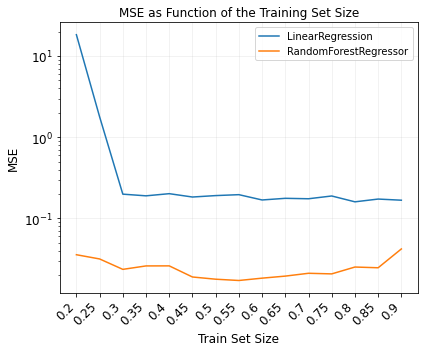

2020-05-06 08:58:36,131: DEBUG ==> Plot saved in ./img/mse_train_size.


In [13]:
from sklearn.metrics      import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble     import RandomForestRegressor
from mltools.libplot      import Plot

# choose an estimator
estimators  = [LinearRegression(),
               RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=RAND)
              ]

# define the size of the train set we want to experiment
train_sizes = np.linspace(20, 90,
                          num=15,
                          dtype=np.int
                         ).reshape(1,-1) / 100.0 #------------------------------------------ training sizes
mse_values  = np.zeros((np.shape(estimators)[0], train_sizes.shape[1])) #------------------- mse values (shape: n_estimators x train_sizes)

# iterate over the training set sizes
for n in range(train_sizes.shape[1]):
    # split the set and select the features
    train, val = train_test_split(df_red_train,
                                  train_size=train_sizes[:,n].reshape(-1,),
                                  shuffle=False
                                 ) #-------------------------------------------------------- split the training set
    train_features = train.drop(columns='exp') #-------------------------------------------- training features
    val_features   = val.drop(columns='exp') #---------------------------------------------- validation features

    train_label    = train['exp'] #--------------------------------------------------------- training label
    val_label      = val['exp'] #----------------------------------------------------------- validation label

    # evaluate the algorithm
    for m in range(np.shape(estimators)[0]):
        estimators[m].fit(train_features, train_label) #------------------------------------ fit the estimator_1
        mse_values[m,n] = mean_squared_error(y_true=val_label,
                                             y_pred=estimators[m].predict(val_features)
                                            ) #--------------------------------------------- store the values of the MSE

# plot the MSE values
plot = Plot()

for m in range(np.shape(estimators)[0]):
    plot.series2D(data=mse_values[m,:],
                    title='MSE as Function of the Training Set Size',
                    xlabel='Train Set Size',
                    ylabel='MSE',
                    legend=estimators[m].__class__.__name__,
                    ylog=True,
                    labels=train_sizes.reshape(-1,)
                   )

plot.save_and_close(path.join(IMG_PATH, 'mse_train_size'))
log.debug('Plot saved in {}.'.format(path.join(IMG_PATH, 'mse_train_size')))

In the plot we show the progression of the MSE as a function of the training size. A good compromise between the no. of samples in the training set and the MSE of different kinds of algorithms seems to be around 80% to 85% of the dataset.

We will therefore divide the original training set as follows:

- 20% into a **test set** (already split),
- 33% into **cross-validation** splits (around 20% of the training dataset),
- 67% into the effective **training set** (around 80% of the training dataset).

When we implement cross-validation in _Scikit_ we will therefore use 5 splits.

In [14]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=False)

## Machine Learning Analysis

We now move to the ML analysis of the dataset. Given the size of the dataframe, we will try different approaches to the extrapolation of the level-$\infty$ predictions. Specifically we will look at:

- [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to have a solid baseline for comparison,
- [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) to implement **L1** and/or **L2** regularization,
- [Linear SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) to use **support vector machines** to improve the predictions,
- [SVR (Gaussian kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) to hopefully find better results,
- [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to use the power of **decision trees** and **ensemble** learning,
- [Histogram Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) to improve the predictive abilities of a single decision tree through successive improvement.

For the hyperparameter optimization we use a [**Bayesan** approach](https://en.wikipedia.org/wiki/Bayesian_optimization) in the [_Scikit-optimize_](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) library: this will provide a better approach to the minimization of the cost functions during cross-validation with respect to a randomized search (apart from the linear regression where we will test all possible values of the hyperparameters). In order to print the output of the parameters dictionaries we implement a function to pretty print them:

In [15]:
def pretty(dct, indent=True):
    '''
    Pretty print the dictionary of best parameters.
    
    Required argument:
        dct:    the dictionary to pretty print.
        
    Optional argument:
        indent: whether to indent the printed output.
    '''
    
    for key, value in dct.items():
        if indent:
            print('    {} = {}'.format(key, value))
        else:
            print('{} = {}'.format(key, value))

### Features and Labels Extraction

We then extract the training features and the labels. If needed we can implement the scaling of the features.

In [16]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# features
features_red  = df_red_train.drop(columns='exp')
features_full = df_full_train.drop(columns='exp')

# scale the features
red_scaler  = StandardScaler()
full_scaler = StandardScaler()

if red_scaler is not None:
    features_red  = red_scaler.fit_transform(features_red)
if full_scaler is not None:
    features_full = full_scaler.fit_transform(features_full)

# labels
label_red  = df_red_train['exp']
label_full = df_full_train['exp']

We will often refer to _reduced_ and _full_ datasets: the first does not contain the initialization values `init`, while the latter does.

### [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

We first consider a linear regression algorithm. In this case the number of hyperparameters to be tuned is small and we can use a **grid search** to try out every combination:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$.

In [17]:
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import mean_squared_error
from mltools.libscore        import ViewCV
from mltools.libplot         import Plot

import joblib

# parameter dictionary
search_params  = {'fit_intercept': [0, 1],
                  'normalize':     [0, 1]
                 } #----------------------------------------------------------------------------------- define hyperparameter grid

# optimization search
estimator      = LinearRegression()
cv_hypersearch = GridSearchCV(estimator=estimator,
                              param_grid=search_params,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              refit=True,
                              cv=cv
                             ) #----------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the {}...'.format(estimator.__class__.__name__))

est_red_fit  = cv_hypersearch.fit(features_red, label_red) #------------------------------------------- fit the estimator (reduced dataset)
joblib.dump(est_red_fit.best_estimator_, path.join(MOD_PATH, '{}_red.joblib'.format(estimator.__class__.__name__)))

results_red  = ViewCV(est_red_fit) #------------------------------------------------------------------- get the scoring results (reduced dataset)
print('\nBest parameters with the reduced dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_red.best_parameters)

print('\nRMSE of {} on the validation set with the reduced dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                            np.sqrt(-results_red.test_mean()),
                                                                                            np.sqrt(results_red.test_std())
                                                                                           )
     )

est_full_fit = cv_hypersearch.fit(features_full, label_full) #----------------------------------------- fit the estimator (full dataset)
joblib.dump(est_full_fit.best_estimator_, path.join(MOD_PATH, '{}_full.joblib'.format(estimator.__class__.__name__)))

results_full = ViewCV(est_full_fit) #------------------------------------------------------------------ get the scoring results (full dataset)
print('\nBest parameters with the full dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_full.best_parameters)

print('\nRMSE of {} on the validation set with the full dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                         np.sqrt(-results_full.test_mean()),
                                                                                         np.sqrt(results_full.test_std())
                                                                                        )
     )

2020-05-06 08:58:36,183: INFO ==> Fitting the LinearRegression...



Best parameters with the reduced dataset for LinearRegression:

    fit_intercept = 1
    normalize = 1

RMSE of LinearRegression on the validation set with the reduced dataset: 0.439 ± 0.228

Best parameters with the full dataset for LinearRegression:

    fit_intercept = 1
    normalize = 0

RMSE of LinearRegression on the validation set with the full dataset: 0.429 ± 0.215


### [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

We then try to implement the regularized version of the simple linear regression: we use an **elastic net** because it implements both **L1** and **L2** regularizations and can be a guide in choosing the appropriate values. In fact the hyperparameters in this case allow to separately control the two different regularizations. The additional term (with respect to the linear regression) to the cost function is of the form $\Delta J(w) = \alpha l_{1\,ratio} \vert\vert w \vert\vert + \frac{\alpha}{2} (1 - l_{1\,ratio}) \vert\vert w \vert\vert^2$. We will then study the following hyperparamter space:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$,
- `alpha` $\in \left[ 0.0, 2.0 \right]$,
- `l1_ratio` $\in \left[ 0.0, 1.0 \right]$.

In [18]:
from sklearn.linear_model import ElasticNet
from skopt                import BayesSearchCV
from skopt.space          import Real, Integer, Categorical
from sklearn.metrics      import mean_squared_error
from mltools.libscore     import ViewCV
from mltools.libplot      import Plot

import joblib

# parameter dictionary
search_params  = {'fit_intercept': Integer(0, 1),
                  'normalize':     Integer(0, 1),
                  'alpha':         Real(0.0, 2.0, prior='uniform'),
                  'l1_ratio':      Real(0.0, 1.0, prior='uniform')
                 } #----------------------------------------------------------------------------------- define hyperparameter grid

# optimization search
estimator      = ElasticNet(max_iter=1e5, random_state=RAND)
cv_hypersearch = BayesSearchCV(estimator=estimator,
                               search_spaces=search_params,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               refit=True,
                               n_iter=100,
                               random_state=RAND,
                               cv=cv
                              ) #---------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the {}...'.format(estimator.__class__.__name__))

est_red_fit  = cv_hypersearch.fit(features_red, label_red) #------------------------------------------- fit the estimator (reduced dataset)
joblib.dump(est_red_fit.best_estimator_, path.join(MOD_PATH, '{}_red.joblib'.format(estimator.__class__.__name__)))

results_red  = ViewCV(est_red_fit) #------------------------------------------------------------------- get the scoring results (reduced dataset)
print('\nBest parameters with the reduced dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_red.best_parameters)

print('\nRMSE of {} on the validation set with the reduced dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                            np.sqrt(-results_red.test_mean()),
                                                                                            np.sqrt(results_red.test_std())
                                                                                           )
     )

est_full_fit = cv_hypersearch.fit(features_full, label_full) #----------------------------------------- fit the estimator (full dataset)
joblib.dump(est_full_fit.best_estimator_, path.join(MOD_PATH, '{}_full.joblib'.format(estimator.__class__.__name__)))

results_full = ViewCV(est_full_fit) #------------------------------------------------------------------ get the scoring results (full dataset)
print('\nBest parameters with the full dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_full.best_parameters)
      
print('\nRMSE of {} on the validation set with the full dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                       np.sqrt(-results_full.test_mean()),
                                                                                       np.sqrt(results_full.test_std())
                                                                                      )
     )

2020-05-06 08:58:38,626: INFO ==> Fitting the ElasticNet...



Best parameters with the reduced dataset for ElasticNet:

    alpha = 0.0
    fit_intercept = 1
    l1_ratio = 0.0
    normalize = 1

RMSE of ElasticNet on the validation set with the reduced dataset: 0.486 ± 0.250

Best parameters with the full dataset for ElasticNet:

    alpha = 0.0
    fit_intercept = 1
    l1_ratio = 0.0
    normalize = 1

RMSE of ElasticNet on the validation set with the full dataset: 0.475 ± 0.230


Notice that after the optimization iterations the best choice for $\alpha$ is identically vanishing: the algorithm works best without regularization. Thus the difference in the results with respect to the linear regression is only due to performance of the two algorithms (the elastic net does not work well when $\alpha = 0$).

### [Linear SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)

We move to the **support vector machines** (SVM) algorithms and start without a **kernel** function. We use the linear implementation of the support vector regressor with hyperparameters:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `epsilon` $\in \left[ 0.0, 1.0 \right]$,
- `C` $\in \left[ 10^{-1}, 10^3 \right]$,
- `loss` $\in \lbrace epsilon\_insensitive, squared\_epsilon\_insensitive \rbrace$,
- `intercept_scaling` $\in \left[ 10^{-2}, 10^2 \right]$.

In [19]:
from sklearn.svm      import LinearSVR
from skopt            import BayesSearchCV
from skopt.space      import Real, Integer, Categorical
from sklearn.metrics  import mean_squared_error
from mltools.libscore import ViewCV
from mltools.libplot  import Plot

import joblib

# parameter dictionary
search_params  = {'fit_intercept':     Integer(0, 1),
                  'epsilon':           Real(0.0, 1.0,  prior='uniform'),
                  'C':                 Real(1.0e-1, 1.0e3, prior='log-uniform'),
                  'intercept_scaling': Real(1.0e-2, 1.0e2, prior='log-uniform'),
                  'loss':              Categorical(['squared_epsilon_insensitive', 'epsilon_insensitive'])
                 } #----------------------------------------------------------------------------------- define hyperparameter grid

# optimization search
estimator      = LinearSVR(max_iter=1e5, random_state=RAND)
cv_hypersearch = BayesSearchCV(estimator=estimator,
                               search_spaces=search_params,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               refit=True,
                               n_iter=100,
                               random_state=RAND,
                               cv=cv
                              ) #---------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the {}...'.format(estimator.__class__.__name__))

est_red_fit  = cv_hypersearch.fit(features_red, label_red) #------------------------------------------- fit the estimator (reduced dataset)
joblib.dump(est_red_fit.best_estimator_, path.join(MOD_PATH, '{}_red.joblib'.format(estimator.__class__.__name__)))

results_red  = ViewCV(est_red_fit) #------------------------------------------------------------------- get the scoring results (reduced dataset)
print('\nBest parameters with the reduced dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_red.best_parameters)

print('\nRMSE of {} on the validation set with the reduced dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                            np.sqrt(-results_red.test_mean()),
                                                                                            np.sqrt(results_red.test_std())
                                                                                           )
     )

est_full_fit = cv_hypersearch.fit(features_full, label_full) #----------------------------------------- fit the estimator (full dataset)
joblib.dump(est_full_fit.best_estimator_, path.join(MOD_PATH, '{}_full.joblib'.format(estimator.__class__.__name__)))

results_full = ViewCV(est_full_fit) #------------------------------------------------------------------ get the scoring results (full dataset)
print('\nBest parameters with the full dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_full.best_parameters)

print('\nRMSE of {} on the validation set with the full dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                         np.sqrt(-results_full.test_mean()),
                                                                                         np.sqrt(results_full.test_std())
                                                                                        )
     )

2020-05-06 09:17:30,063: INFO ==> Fitting the LinearSVR...



Best parameters with the reduced dataset for LinearSVR:

    C = 1000.0
    epsilon = 0.0
    fit_intercept = 1
    intercept_scaling = 0.01
    loss = squared_epsilon_insensitive

RMSE of LinearSVR on the validation set with the reduced dataset: 0.476 ± 0.250

Best parameters with the full dataset for LinearSVR:

    C = 1000.0
    epsilon = 0.0
    fit_intercept = 1
    intercept_scaling = 0.01
    loss = squared_epsilon_insensitive

RMSE of LinearSVR on the validation set with the full dataset: 0.467 ± 0.229


### [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) (Gaussian Kernel)

We now implement a kernel function in the SVM. In particular we use the Gaussian kernel (_rbf_) and try to approximate the level-$\infty$ predictions using these hyperparameters:

- `gamma` $\in \left[ 10^{-1}, 10^1 \right]$,
- `C` $\in \left[ 10^{-1}, 5 \times 10^2 \right]$,
- `epsilon` $\in \left[ 10^{-4}, 10^{-1} \right]$,
- `shrinking` $\in \lbrace 0, 1 \rbrace$.

In [20]:
from sklearn.svm      import SVR
from skopt            import BayesSearchCV
from skopt.space      import Real, Integer, Categorical
from sklearn.metrics  import mean_squared_error
from mltools.libscore import ViewCV
from mltools.libplot  import Plot

import joblib

# parameter dictionary
search_params  = {'epsilon':   Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                  'C':         Real(1.0e-1, 5.0e2,  prior='log-uniform'),
                  'gamma':     Real(1.0e-1, 1.0e1,  prior='log-uniform'),
                  'shrinking': Integer(0, 1)
                 } #----------------------------------------------------------------------------------- define hyperparameter grid

# optimization search
estimator      = SVR(kernel='rbf')
cv_hypersearch = BayesSearchCV(estimator=estimator,
                               search_spaces=search_params,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               refit=True,
                               n_iter=100,
                               random_state=RAND,
                               cv=cv
                              ) #---------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the {}...'.format(estimator.__class__.__name__))

est_red_fit  = cv_hypersearch.fit(features_red, label_red) #------------------------------------------- fit the estimator (reduced dataset)
joblib.dump(est_red_fit.best_estimator_, path.join(MOD_PATH, '{}_red.joblib'.format(estimator.__class__.__name__)))

results_red  = ViewCV(est_red_fit) #------------------------------------------------------------------- get the scoring results (reduced dataset)
print('\nBest parameters with the reduced dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_red.best_parameters)

print('\nRMSE of {} on the validation set with the reduced dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                            np.sqrt(-results_red.test_mean()),
                                                                                            np.sqrt(results_red.test_std())
                                                                                           )
     )

est_full_fit = cv_hypersearch.fit(features_full, label_full) #----------------------------------------- fit the estimator (full dataset)
joblib.dump(est_full_fit.best_estimator_, path.join(MOD_PATH, '{}_full.joblib'.format(estimator.__class__.__name__)))

results_full = ViewCV(est_full_fit) #------------------------------------------------------------------ get the scoring results (full dataset)
print('\nBest parameters with the full dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_full.best_parameters)

print('\nRMSE of {} on the validation set with the full dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                         np.sqrt(-results_full.test_mean()),
                                                                                         np.sqrt(results_full.test_std())
                                                                                        )
     )

2020-05-06 09:56:27,128: INFO ==> Fitting the SVR...



Best parameters with the reduced dataset for SVR:

    C = 127.78452073999996
    epsilon = 0.0001
    gamma = 1.1226049684634154
    shrinking = 1

RMSE of SVR on the validation set with the reduced dataset: 0.171 ± 0.120

Best parameters with the full dataset for SVR:

    C = 185.80660504934193
    epsilon = 0.0001
    gamma = 0.35728113527327415
    shrinking = 1

RMSE of SVR on the validation set with the full dataset: 0.111 ± 0.070


### [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Moving on to the **decision tree** family of algorithms, we implement the **random forest** regression in the _Scikit_ implementation. We will try to intervene on as many hyperparameters as possible both to avoid overfitting the training set and to be able to generalise to new results. We use the following hyperparameters:

- `n_estimators` $\in \left[ 10, 10^3 \right]$,
- `criterion` $\in \lbrace mse, mae \rbrace$,
- `max_depth` $\in \left[ 2, 100 \right]$,
- `min_samples_split` $\in \left[ 2, 100 \right]$,
- `min_samples_leaf` $\in \left[ 1, 100 \right]$,
- `min_weight_fraction_leaf` $\in \left[ 0, 0.5\right]$,
- `max_leaf_nodes` $\in \left[ 2, 100 \right]$.

In [21]:
from sklearn.ensemble import RandomForestRegressor
from skopt            import BayesSearchCV
from skopt.space      import Real, Integer, Categorical
from sklearn.metrics  import mean_squared_error
from mltools.libscore import ViewCV
from mltools.libplot  import Plot

import joblib

# parameter dictionary
search_params = {'n_estimators':             Integer(1.0e1, 1.0e3, prior='log-uniform'),
                 'max_depth':                Integer(2, 100, prior='uniform'),
                 'min_samples_split':        Integer(2, 100, prior='uniform'),
                 'min_samples_leaf':         Integer(1, 100, prior='uniform'),
                 'max_leaf_nodes':           Integer(2, 100, prior='uniform'),
                 'min_weight_fraction_leaf': Real(0.0, 0.5, prior='uniform'),
                 'criterion':                Categorical(['mse', 'mae'])
                } #------------------------------------------------------------------------------------ define hyperparameter grid

# optimization search
estimator      = RandomForestRegressor(n_jobs=-1, random_state=RAND)
cv_hypersearch = BayesSearchCV(estimator=estimator,
                               search_spaces=search_params,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               refit=True,
                               n_iter=50,
                               random_state=RAND,
                               cv=cv
                              ) #---------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the {}...'.format(estimator.__class__.__name__))

est_red_fit  = cv_hypersearch.fit(features_red, label_red) #------------------------------------------- fit the estimator (reduced dataset)
joblib.dump(est_red_fit.best_estimator_, path.join(MOD_PATH, '{}_red.joblib'.format(estimator.__class__.__name__)))

results_red  = ViewCV(est_red_fit) #------------------------------------------------------------------- get the scoring results (reduced dataset)
print('\nBest parameters with the reduced dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_red.best_parameters)

print('\nRMSE of {} on the validation set with the reduced dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                            np.sqrt(-results_red.test_mean()),
                                                                                            np.sqrt(results_red.test_std())
                                                                                           )
     )

est_full_fit = cv_hypersearch.fit(features_full, label_full) #----------------------------------------- fit the estimator (full dataset)
joblib.dump(est_full_fit.best_estimator_, path.join(MOD_PATH, '{}_full.joblib'.format(estimator.__class__.__name__)))

results_full = ViewCV(est_full_fit) #------------------------------------------------------------------ get the scoring results (full dataset)
print('\nBest parameters with the full dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_full.best_parameters)

print('\nRMSE of {} on the validation set with the full dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                         np.sqrt(-results_full.test_mean()),
                                                                                         np.sqrt(results_full.test_std())
                                                                                        )
     )

2020-05-06 10:15:04,532: INFO ==> Fitting the RandomForestRegressor...



Best parameters with the reduced dataset for RandomForestRegressor:

    criterion = mae
    max_depth = 95
    max_leaf_nodes = 100
    min_samples_leaf = 1
    min_samples_split = 2
    min_weight_fraction_leaf = 0.0
    n_estimators = 891

RMSE of RandomForestRegressor on the validation set with the reduced dataset: 0.137 ± 0.099

Best parameters with the full dataset for RandomForestRegressor:

    criterion = mse
    max_depth = 100
    max_leaf_nodes = 100
    min_samples_leaf = 1
    min_samples_split = 2
    min_weight_fraction_leaf = 0.0
    n_estimators = 10

RMSE of RandomForestRegressor on the validation set with the full dataset: 0.124 ± 0.099


### [Histogram Based Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

We consider the new (still _experimental_) version of _Scikit_ **gradient boosting** algorithm, which is **histogram bases**. This should automatically handle _NaN_ gradients and be quite faster than the usual implementation. We will consider the followin hyperparameters:

- `loss` $\in \lbrace least\_squares, least\_absolute\_deviation \rbrace$,
- `learning_rate` $\in \left[ 10^{-4}, 10^{-1} \right]$,
- `max_iter` $\in \left[ 10, 10^3 \right]$,
- `max_depth` $\in \left[ 2, 100 \right]$,
- `min_samples_leaf` $\in \left[ 10, 100 \right]$,
- `l2_regularization` $\in \left[ 10^{-6}, 10^2 \right]$,
- `max_leaf_nodes` $\in \left[ 2, 50 \right]$.

In [22]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble     import HistGradientBoostingRegressor
from skopt                import BayesSearchCV
from skopt.space          import Real, Integer, Categorical
from sklearn.metrics      import mean_squared_error
from mltools.libscore     import ViewCV
from mltools.libplot      import Plot

import joblib

# parameter dictionary
search_params = {'max_iter':          Integer(1.0e1, 1.0e3, prior='log-uniform'),
                 'max_depth':         Integer(2, 100,  prior='uniform'),
                 'max_leaf_nodes':    Integer(2, 50,   prior='uniform'),
                 'min_samples_leaf':  Integer(10, 100, prior='uniform'),
                 'learning_rate':     Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                 'l2_regularization': Real(1.0e-6, 1.0e2,  prior='log-uniform'),
                 'loss':              Categorical(['least_squares', 'least_absolute_deviation'])
                } #------------------------------------------------------------------------------------- define the hyperparameter grid

# optimization search
estimator      = HistGradientBoostingRegressor(scoring='loss', validation_fraction=None, n_iter_no_change=10, random_state=RAND)
cv_hypersearch = BayesSearchCV(estimator=estimator,
                               search_spaces=search_params,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               refit=True,
                               n_iter=50,
                               random_state=RAND,
                               cv=cv
                              ) #---------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the {}...'.format(estimator.__class__.__name__))

est_red_fit  = cv_hypersearch.fit(features_red, label_red) #------------------------------------------- fit the estimator (reduced dataset)
joblib.dump(est_red_fit.best_estimator_, path.join(MOD_PATH, '{}_red.joblib'.format(estimator.__class__.__name__)))

results_red  = ViewCV(est_red_fit) #------------------------------------------------------------------- get the scoring results (reduced dataset)
print('\nBest parameters with the reduced dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_red.best_parameters)

print('\nRMSE of {} on the validation set with the reduced dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                            np.sqrt(-results_red.test_mean()),
                                                                                            np.sqrt(results_red.test_std())
                                                                                           )
     )

est_full_fit = cv_hypersearch.fit(features_full, label_full) #----------------------------------------- fit the estimator (full dataset)
joblib.dump(est_full_fit.best_estimator_, path.join(MOD_PATH, '{}_full.joblib'.format(estimator.__class__.__name__)))

results_full = ViewCV(est_full_fit) #------------------------------------------------------------------ get the scoring results (full dataset)
print('\nBest parameters with the full dataset for {}:\n'.format(estimator.__class__.__name__))
pretty(results_full.best_parameters)

print('\nRMSE of {} on the validation set with the full dataset: {:.3f} ± {:.3f}'.format(estimator.__class__.__name__,
                                                                                         np.sqrt(-results_full.test_mean()),
                                                                                         np.sqrt(results_full.test_std())
                                                                                        )
     )

2020-05-06 10:28:05,351: INFO ==> Fitting the HistGradientBoostingRegressor...



Best parameters with the reduced dataset for HistGradientBoostingRegressor:

    l2_regularization = 5.001575677983704
    learning_rate = 0.044662788252242826
    loss = least_squares
    max_depth = 95
    max_iter = 865
    max_leaf_nodes = 5
    min_samples_leaf = 22

RMSE of HistGradientBoostingRegressor on the validation set with the reduced dataset: 0.108 ± 0.091

Best parameters with the full dataset for HistGradientBoostingRegressor:

    l2_regularization = 5.001575677983704
    learning_rate = 0.044662788252242826
    loss = least_squares
    max_depth = 95
    max_iter = 865
    max_leaf_nodes = 5
    min_samples_leaf = 22

RMSE of HistGradientBoostingRegressor on the validation set with the full dataset: 0.092 ± 0.071


## Discussion and Test Set Performance

It seems that in general the **linear models** perform at best when **no regularization** is involved, thus the simple **linear regression** model represents a very good baseline for improvement. The **support vector machines** perform better in the presence of a kernel function (**Gaussian** in this case) and improve the results of the linear regression. In principle also the **random forest** regression is a very good prediction algorithm in this case even though it is strongly influenced by the presence of the initial values in the dataset. However, in the family of decision trees, the **boosted trees** vastly outperform the random forest, especially when the initial values are not present. 

Notice that we applied a scaler at the beginning in order to improve the convergence of the algorithms.

In [23]:
import joblib

from sklearn.metrics import mean_squared_error

# load the models for the reduced dataset
if path.isfile(path.join(MOD_PATH, 'LinearRegression_red.joblib')):
    lin_reg_red = joblib.load(path.join(MOD_PATH, 'LinearRegression_red.joblib'))
    log.debug('Load linear regression for the reduced dataset.')
else:
    log.error('Cannot find linear regression model for the reduced dataset!')

if path.isfile(path.join(MOD_PATH, 'ElasticNet_red.joblib')):
    el_net_red = joblib.load(path.join(MOD_PATH, 'ElasticNet_red.joblib'))
    log.debug('Load elastic net for the reduced dataset.')
else:
    log.error('Cannot find elastic net model for the reduced dataset!')

if path.isfile(path.join(MOD_PATH, 'LinearSVR_red.joblib')):
    lin_svr_red = joblib.load(path.join(MOD_PATH, 'LinearSVR_red.joblib'))
    log.debug('Load linear svr for the reduced dataset.')
else:
    log.error('Cannot find linear svr model for the reduced dataset!')

if path.isfile(path.join(MOD_PATH, 'SVR_red.joblib')):
    svr_red = joblib.load(path.join(MOD_PATH, 'SVR_red.joblib'))
    log.debug('Load svr for the reduced dataset.')
else:
    log.error('Cannot find svr model for the reduced dataset!')

if path.isfile(path.join(MOD_PATH, 'RandomForestRegressor_red.joblib')):
    rnd_for_red = joblib.load(path.join(MOD_PATH, 'RandomForestRegressor_red.joblib'))
    log.debug('Load random forest for the reduced dataset.')
else:
    log.error('Cannot find random forest model for the reduced dataset!')

if path.isfile(path.join(MOD_PATH, 'HistGradientBoostingRegressor_red.joblib')):
    grd_boost_red = joblib.load(path.join(MOD_PATH, 'HistGradientBoostingRegressor_red.joblib'))
    log.debug('Load boosted trees for the reduced dataset.')
else:
    log.error('Cannot find boosted trees model for the reduced dataset!')
    
# load the models for the full dataset
if path.isfile(path.join(MOD_PATH, 'LinearRegression_full.joblib')):
    lin_reg_full = joblib.load(path.join(MOD_PATH, 'LinearRegression_full.joblib'))
    log.debug('Load linear regression for the full dataset.')
else:
    log.error('Cannot find linear regression model for the full dataset!')

if path.isfile(path.join(MOD_PATH, 'ElasticNet_full.joblib')):
    el_net_full = joblib.load(path.join(MOD_PATH, 'ElasticNet_full.joblib'))
    log.debug('Load elastic net for the full dataset.')
else:
    log.error('Cannot find elastic net model for the full dataset!')

if path.isfile(path.join(MOD_PATH, 'LinearSVR_full.joblib')):
    lin_svr_full = joblib.load(path.join(MOD_PATH, 'LinearSVR_full.joblib'))
    log.debug('Load linear svr for the full dataset.')
else:
    log.error('Cannot find linear svr model for the full dataset!')

if path.isfile(path.join(MOD_PATH, 'SVR_full.joblib')):
    svr_full = joblib.load(path.join(MOD_PATH, 'SVR_full.joblib'))
    log.debug('Load svr for the full dataset.')
else:
    log.error('Cannot find svr model for the full dataset!')

if path.isfile(path.join(MOD_PATH, 'RandomForestRegressor_full.joblib')):
    rnd_for_full = joblib.load(path.join(MOD_PATH, 'RandomForestRegressor_full.joblib'))
    log.debug('Load random forest for the full dataset.')
else:
    log.error('Cannot find random forest model for the full dataset!')

if path.isfile(path.join(MOD_PATH, 'HistGradientBoostingRegressor_full.joblib')):
    grd_boost_full = joblib.load(path.join(MOD_PATH, 'HistGradientBoostingRegressor_full.joblib'))
    log.debug('Load boosted trees for the full dataset.')
else:
    log.error('Cannot find boosted trees model for the full dataset!')

2020-05-06 10:37:37,982: DEBUG ==> Load linear regression for the reduced dataset.
2020-05-06 10:37:37,984: DEBUG ==> Load elastic net for the reduced dataset.
2020-05-06 10:37:37,986: DEBUG ==> Load linear svr for the reduced dataset.
2020-05-06 10:37:37,988: DEBUG ==> Load svr for the reduced dataset.
2020-05-06 10:37:38,211: DEBUG ==> Load random forest for the reduced dataset.
2020-05-06 10:37:38,268: DEBUG ==> Load boosted trees for the reduced dataset.
2020-05-06 10:37:38,270: DEBUG ==> Load linear regression for the full dataset.
2020-05-06 10:37:38,272: DEBUG ==> Load elastic net for the full dataset.
2020-05-06 10:37:38,273: DEBUG ==> Load linear svr for the full dataset.
2020-05-06 10:37:38,275: DEBUG ==> Load svr for the full dataset.
2020-05-06 10:37:38,279: DEBUG ==> Load random forest for the full dataset.
2020-05-06 10:37:38,332: DEBUG ==> Load boosted trees for the full dataset.


We now show the performance on the test set, which basically confirms what we could have expected from the evaluation on the cross-validation sets:

In [24]:
# features
features_test_red  = df_red_test.drop(columns='exp')
if isinstance(red_scaler, (skl.preprocessing.RobustScaler, skl.preprocessing.StandardScaler, skl.preprocessing.MinMaxScaler)):
    features_test_red = red_scaler.transform(features_test_red)
    
features_test_full = df_full_test.drop(columns='exp')
if isinstance(full_scaler, (skl.preprocessing.RobustScaler, skl.preprocessing.StandardScaler, skl.preprocessing.MinMaxScaler)):
    features_test_full = full_scaler.transform(features_test_full)

# labels
label_test_red  = df_red_test['exp']
label_test_full = df_full_test['exp']

# compute performance
print('\nRMSE of the {} on the test set of the reduced dataset: {:.3f}'.format(lin_reg_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_red, y_pred=lin_reg_red.predict(features_test_red)))))
print('RMSE of the {} on the test set of the reduced dataset: {:.3f}'.format(el_net_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_red, y_pred=el_net_red.predict(features_test_red)))))
print('RMSE of the {} on the test set of the reduced dataset: {:.3f}'.format(lin_svr_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_red, y_pred=lin_svr_red.predict(features_test_red)))))
print('RMSE of the {} on the test set of the reduced dataset: {:.3f}'.format(svr_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_red, y_pred=svr_red.predict(features_test_red)))))
print('RMSE of the {} on the test set of the reduced dataset: {:.3f}'.format(rnd_for_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_red, y_pred=rnd_for_red.predict(features_test_red)))))
print('RMSE of the {} on the test set of the reduced dataset: {:.3f}'.format(grd_boost_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_red, y_pred=grd_boost_red.predict(features_test_red)))))

print('\nRMSE of the {} on the test set of the full dataset: {:.3f}'.format(lin_reg_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_full, y_pred=lin_reg_full.predict(features_test_full)))))
print('RMSE of the {} on the test set of the full dataset: {:.3f}'.format(el_net_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_full, y_pred=el_net_full.predict(features_test_full)))))
print('RMSE of the {} on the test set of the full dataset: {:.3f}'.format(lin_svr_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_full, y_pred=lin_svr_full.predict(features_test_full)))))
print('RMSE of the {} on the test set of the full dataset: {:.3f}'.format(svr_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_full, y_pred=svr_full.predict(features_test_full)))))
print('RMSE of the {} on the test set of the full dataset: {:.3f}'.format(rnd_for_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_full, y_pred=rnd_for_full.predict(features_test_full)))))
print('RMSE of the {} on the test set of the full dataset: {:.3f}'.format(grd_boost_red.__class__.__name__, np.sqrt(mean_squared_error(y_true=label_test_full, y_pred=grd_boost_full.predict(features_test_full)))))


RMSE of the LinearRegression on the test set of the reduced dataset: 0.410
RMSE of the ElasticNet on the test set of the reduced dataset: 0.491
RMSE of the LinearSVR on the test set of the reduced dataset: 0.463
RMSE of the SVR on the test set of the reduced dataset: 0.189
RMSE of the RandomForestRegressor on the test set of the reduced dataset: 0.159
RMSE of the HistGradientBoostingRegressor on the test set of the reduced dataset: 0.123

RMSE of the LinearRegression on the test set of the full dataset: 0.400
RMSE of the ElasticNet on the test set of the full dataset: 0.471
RMSE of the LinearSVR on the test set of the full dataset: 0.445
RMSE of the SVR on the test set of the full dataset: 0.177
RMSE of the RandomForestRegressor on the test set of the full dataset: 0.115
RMSE of the HistGradientBoostingRegressor on the test set of the full dataset: 0.117


## Stacking and Performance Improvement

We now consider the **stacking ensemble** using the results on the **validation sets** in the previous analysis. We select the algorithms based on their performance and the fact that they should be as different as possible among them. We will therefore select:

- `LinearRegression` (if necessary),
- `SVR`,
- `HistGradientBoostingRegressor`.

We split the original training set in two to create the two training levels and we use a `LinearRegression` as meta-learner.

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from skopt                   import BayesSearchCV
from skopt.space             import Real, Integer, Categorical
from sklearn.linear_model    import LinearRegression
from sklearn.svm             import SVR
from sklearn.experimental    import enable_hist_gradient_boosting
from sklearn.ensemble        import HistGradientBoostingRegressor

# split the training set
lv1_train_red, lv2_train_red, lv1_train_lab_red, lv2_train_lab_red     = train_test_split(features_red, label_red, test_size=0.3, shuffle=False)
lv1_train_full, lv2_train_full, lv1_train_lab_full, lv2_train_lab_full = train_test_split(features_full, label_full, test_size=0.3, shuffle=False)
test_red, test_full, test_label_red, test_label_full                   = features_test_red, features_test_full, label_test_red, label_test_full

We start from the _reduced_ dataset and compute the RMSE on the prediction using the stacking ensemble:

In [29]:
# define the algorithms
#lin_reg = LinearRegression()
svr_rbf = SVR(kernel='rbf')
grd_bst = HistGradientBoostingRegressor(scoring='loss', validation_fraction=None, n_iter_no_change=10, random_state=RAND)

# create search spaces for each of them
#lin_reg_params  = {'fit_intercept': [0, 1],
#                   'normalize':     [0, 1]
#                  }
svr_rbf_params  = {'epsilon':   Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                   'C':         Real(1.0e-1, 1.0e3,  prior='log-uniform'),
                   'gamma':     Real(1.0e-1, 1.0e1,  prior='log-uniform'),
                   'shrinking': Integer(0, 1)
                  }
grd_bst_params = {'max_iter':          Integer(1.0e1, 1.0e3, prior='log-uniform'),
                  'max_depth':         Integer(2, 100,  prior='uniform'),
                  'max_leaf_nodes':    Integer(2, 50,   prior='uniform'),
                  'min_samples_leaf':  Integer(10, 100, prior='uniform'),
                  'learning_rate':     Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                  'l2_regularization': Real(1.0e-6, 1.0e2,  prior='log-uniform'),
                  'loss':              Categorical(['least_squares', 'least_absolute_deviation'])
                 }

# fit the algorithms on the first level for the reduced dataset
#lin_reg_est = GridSearchCV(estimator=lin_reg,
#                           param_grid=lin_reg_params,
#                           scoring='neg_mean_squared_error',
#                           n_jobs=-1,
#                           refit=True,
#                           cv=cv
#                          )
#log.info('Training lv. 1 {}.'.format(lin_reg_est.estimator.__class__.__name__))
#lin_reg_fit = lin_reg_est.fit(lv1_train_red, lv1_train_lab_red)

svr_rbf_est = BayesSearchCV(estimator=svr_rbf,
                            search_spaces=svr_rbf_params,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1,
                            refit=True,
                            n_iter=100,
                            random_state=RAND,
                            cv=cv
                           )
log.info('Training lv. 1 {}.'.format(svr_rbf_est.estimator.__class__.__name__))
svr_rbf_fit = svr_rbf_est.fit(lv1_train_red, lv1_train_lab_red)

grd_bst_est = BayesSearchCV(estimator=grd_bst,
                            search_spaces=grd_bst_params,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1,
                            refit=True,
                            n_iter=20,
                            random_state=RAND,
                            cv=cv
                           )
log.info('Training lv. 1 {}.'.format(grd_bst_est.estimator.__class__.__name__))
grd_bst_fit = grd_bst_est.fit(lv1_train_red, lv1_train_lab_red)

# compute the predictions on the second level of the reduced dataset
#lin_reg_lv2_pred = lin_reg_fit.best_estimator_.predict(lv2_train_red)
svr_rbf_lv2_pred = svr_rbf_fit.best_estimator_.predict(lv2_train_red)
grd_bst_lv2_pred = grd_bst_fit.best_estimator_.predict(lv2_train_red)
stacked_lv2_pred = np.c_[#lin_reg_lv2_pred,
                         svr_rbf_lv2_pred,
                         grd_bst_lv2_pred
                        ]

# compute the predictions on the test data of the reduced dataset
#lin_reg_test_pred = lin_reg_fit.best_estimator_.predict(test_red)
svr_rbf_test_pred = svr_rbf_fit.best_estimator_.predict(test_red)
grd_bst_test_pred = grd_bst_fit.best_estimator_.predict(test_red)
stacked_test_pred = np.c_[#lin_reg_test_pred,
                          svr_rbf_test_pred,
                          grd_bst_test_pred
                         ]

# define the meta learner
log.info('Training meta estimator.')
meta_learner        = HistGradientBoostingRegressor(scoring='loss', validation_fraction=None, n_iter_no_change=10, random_state=RAND)
meta_learner_params = {'max_iter':          Integer(1.0e1, 1.0e3, prior='log-uniform'),
                      'max_depth':         Integer(2, 100,  prior='uniform'),
                      'max_leaf_nodes':    Integer(2, 50,   prior='uniform'),
                      'min_samples_leaf':  Integer(10, 100, prior='uniform'),
                      'learning_rate':     Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                      'l2_regularization': Real(1.0e-6, 1.0e2,  prior='log-uniform'),
                      'loss':              Categorical(['least_squares', 'least_absolute_deviation'])
                     }
meta_learner_est    = BayesSearchCV(estimator=meta_learner,
                                    search_spaces=meta_learner_params,
                                    scoring='neg_mean_squared_error',
                                    n_jobs=-1,
                                    refit=True,
                                    n_iter=50,
                                    random_state=RAND,
                                    cv=cv
                                   )
meta_learner_fit    = meta_learner_est.fit(stacked_lv2_pred, lv2_train_lab_red)

# compute the final predictions
red_predictions = meta_learner_fit.best_estimator_.predict(stacked_test_pred)
print('RMSE of the stacked ensemble on the test set: {:.3f}'.format(np.sqrt(mean_squared_error(y_true=test_label_red, y_pred=red_predictions))))

2020-05-06 11:05:33,523: INFO ==> Training lv. 1 SVR.
2020-05-06 11:16:41,277: INFO ==> Training lv. 1 HistGradientBoostingRegressor.
2020-05-06 11:19:05,113: INFO ==> Training meta estimator.


RMSE of the stacked ensemble on the test set: 0.092


We can then repeat the same analysis also for the _full_ dataset:

In [30]:
# define the algorithms
#lin_reg = LinearRegression()
svr_rbf = SVR(kernel='rbf')
grd_bst = HistGradientBoostingRegressor(scoring='loss', validation_fraction=None, n_iter_no_change=10, random_state=RAND)

# create search spaces for each of them
#lin_reg_params  = {'fit_intercept': [0, 1],
#                   'normalize':     [0, 1]
#                  }
svr_rbf_params  = {'epsilon':   Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                   'C':         Real(1.0e-1, 1.0e3,  prior='log-uniform'),
                   'gamma':     Real(1.0e-1, 1.0e1,  prior='log-uniform'),
                   'shrinking': Integer(0, 1)
                  }
grd_bst_params = {'max_iter':          Integer(1.0e1, 1.0e3, prior='log-uniform'),
                  'max_depth':         Integer(2, 100,  prior='uniform'),
                  'max_leaf_nodes':    Integer(2, 50,   prior='uniform'),
                  'min_samples_leaf':  Integer(10, 100, prior='uniform'),
                  'learning_rate':     Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                  'l2_regularization': Real(1.0e-6, 1.0e2,  prior='log-uniform'),
                  'loss':              Categorical(['least_squares', 'least_absolute_deviation'])
                 }

# fit the algorithms on the first level for the reduced dataset
#lin_reg_est = GridSearchCV(estimator=lin_reg,
#                           param_grid=lin_reg_params,
#                           scoring='neg_mean_squared_error',
#                           n_jobs=-1,
#                           refit=True,
#                           cv=cv
#                          )
#log.info('Training lv. 1 {}.'.format(lin_reg_est.estimator.__class__.__name__))
#lin_reg_fit = lin_reg_est.fit(lv1_train_full, lv1_train_lab_full)

svr_rbf_est = BayesSearchCV(estimator=svr_rbf,
                            search_spaces=svr_rbf_params,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1,
                            refit=True,
                            n_iter=100,
                            random_state=RAND,
                            cv=cv
                           )
log.info('Training lv. 1 {}.'.format(svr_rbf_est.estimator.__class__.__name__))
svr_rbf_fit = svr_rbf_est.fit(lv1_train_full, lv1_train_lab_full)

grd_bst_est = BayesSearchCV(estimator=grd_bst,
                            search_spaces=grd_bst_params,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1,
                            refit=True,
                            n_iter=20,
                            random_state=RAND,
                            cv=cv
                           )
log.info('Training lv. 1 {}.'.format(grd_bst_est.estimator.__class__.__name__))
grd_bst_fit = grd_bst_est.fit(lv1_train_full, lv1_train_lab_full)

# compute the predictions on the second level of the reduced dataset
#lin_reg_lv2_pred = lin_reg_fit.best_estimator_.predict(lv2_train_full)
svr_rbf_lv2_pred = svr_rbf_fit.best_estimator_.predict(lv2_train_full)
grd_bst_lv2_pred = grd_bst_fit.best_estimator_.predict(lv2_train_full)
stacked_lv2_pred = np.c_[#lin_reg_lv2_pred,
                         svr_rbf_lv2_pred,
                         grd_bst_lv2_pred
                        ]

# compute the predictions on the test data of the reduced dataset
#lin_reg_test_pred = lin_reg_fit.best_estimator_.predict(test_full)
svr_rbf_test_pred = svr_rbf_fit.best_estimator_.predict(test_full)
grd_bst_test_pred = grd_bst_fit.best_estimator_.predict(test_full)
stacked_test_pred = np.c_[#lin_reg_test_pred,
                          svr_rbf_test_pred,
                          grd_bst_test_pred
                         ]

# define the meta learner
log.info('Training meta estimator.')
meta_learner        = HistGradientBoostingRegressor(scoring='loss', validation_fraction=None, n_iter_no_change=10, random_state=RAND)
meta_learner_params = {'max_iter':          Integer(1.0e1, 1.0e3, prior='log-uniform'),
                      'max_depth':         Integer(2, 100,  prior='uniform'),
                      'max_leaf_nodes':    Integer(2, 50,   prior='uniform'),
                      'min_samples_leaf':  Integer(10, 100, prior='uniform'),
                      'learning_rate':     Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                      'l2_regularization': Real(1.0e-6, 1.0e2,  prior='log-uniform'),
                      'loss':              Categorical(['least_squares', 'least_absolute_deviation'])
                     }
meta_learner_est     = BayesSearchCV(estimator=meta_learner,
                                     search_spaces=meta_learner_params,
                                     scoring='neg_mean_squared_error',
                                     n_jobs=-1,
                                     refit=True,
                                     n_iter=50,
                                     random_state=RAND,
                                     cv=cv
                                    )
meta_learner_fit     = meta_learner_est.fit(stacked_lv2_pred, lv2_train_lab_red)

# compute the final predictions
full_predictions = meta_learner_fit.best_estimator_.predict(stacked_test_pred)
print('RMSE of the stacked ensemble on the test set: {:.3f}'.format(np.sqrt(mean_squared_error(y_true=test_label_full, y_pred=full_predictions))))

2020-05-06 11:24:56,883: INFO ==> Training lv. 1 SVR.
2020-05-06 11:36:01,861: INFO ==> Training lv. 1 HistGradientBoostingRegressor.
2020-05-06 11:37:03,430: INFO ==> Training meta estimator.


RMSE of the stacked ensemble on the test set: 0.214


Which however does not improve the level-$\infty$ predictions with respect to the isolate learner.

## Discussion

It seems that using a stacking ensemble on the dataset **without** the starting point helps in the prediction of the level-$\infty$ extrapolation.